# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [38]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

c:\Users\Ujval\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

c:\Users\Ujval\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
df_transactions_pivot = df_transactions.pivot(index='customer_name', columns= 'offer_id', values='n').fillna(0).astype('int').reset_index()
df_transactions_pivot.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Devon's Answer: Regarding the optimal SSE values for K-Means, we want sometime small but not tiny. The actual values depend on the number of data points, so let's say that the maximum SSE after running K-Means is 10 for k=1 and goes down with increasing k.  In this scenario, I would aim for an SSE of 1-2, but reject anything under 1 as overfitting.

In [ ]:
# your turn
# Run KMeans on the existing data - here I will assume 3 clusters for now, based on nothing
x_cols = df_transactions_pivot.drop('customer_name', axis=1)
km = KMeans(n_clusters=3)
y_pred = km.fit_predict(x_cols)
print(y_pred)

[0 2 1 0 2 2 1 0 2 0 2 1 0 2 2 1 2 1 0 2 0 2 2 2 1 2 2 2 2 2 2 2 2 2 2 0 2
 0 2 0 1 1 2 2 0 2 0 2 2 2 2 2 2 1 2 0 1 2 0 2 2 2 2 0 0 1 1 2 2 2 2 2 2 0
 2 0 1 2 2 1 2 2 2 1 0 0 0 2 2 2 2 0 2 0 2 2 0 2 2 2]


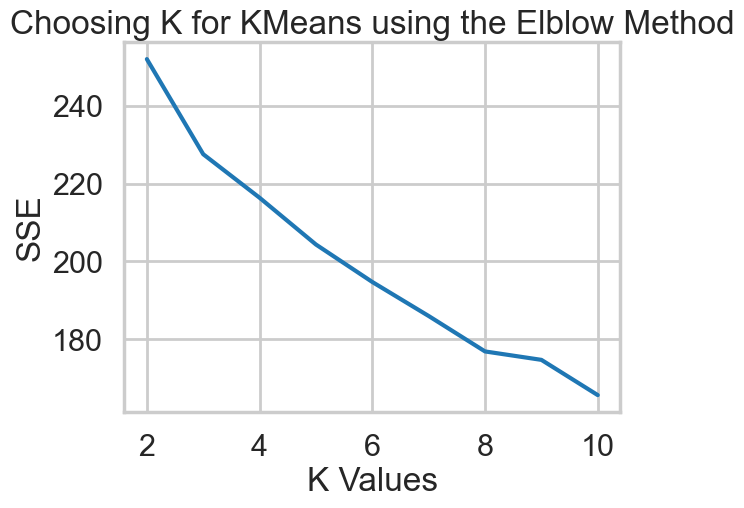

In [ ]:
#Test a range of value for k and plot the SSE

k_values = list(range(2, 11))
SS = []
for k in k_values:
    model = KMeans(n_clusters=k, n_init=10, algorithm="lloyd")
    y_pred = model.fit_predict(x_cols)
    sse = model.inertia_
    SS.append(sse)

sns.lineplot(x=k_values, y=SS, markers='.')
plt.xlabel('K Values')
plt.ylabel('SSE')
plt.title('Choosing K for KMeans using the Elblow Method')
plt.show()

In [ ]:
#Plot bar chart with the number of each data points per cluster for the 'best' k.
# I don't see a very clear elbow, but I think 8 is the closest.  I tried extending out the range of k to find a clearer bend in the lineplot but I didn't find anything obvious.

k_8 = KMeans(n_clusters=8, n_init=10, algorithm="lloyd")
y_pred = k_8.fit_predict(x_cols)
labels = k_8.labels_



[1 6 0 1 6 5 0 2 7 1 7 0 1 7 7 0 6 0 1 7 1 2 7 7 0 4 6 7 6 0 6 2 7 3 1 2 7
 1 7 2 0 0 2 6 1 3 2 6 7 7 7 5 6 0 2 2 0 6 1 2 6 2 6 1 1 0 0 6 7 6 6 6 3 1
 6 1 0 2 6 0 4 4 6 0 1 2 1 4 6 2 3 1 6 1 7 6 2 6 3 5]


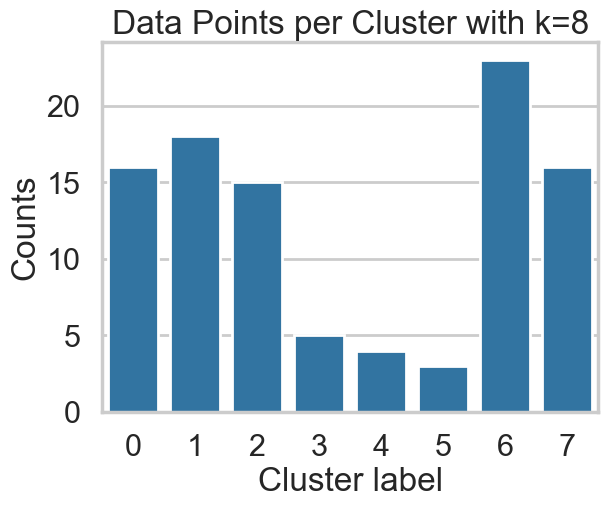

In [21]:
labels = np.array(labels)
values, counts = np.unique(labels, return_counts=True)
sns.barplot(x=values, y=counts)
plt.title('Data Points per Cluster with k=8')
plt.xlabel('Cluster label')
plt.ylabel('Counts')
plt.show()

Devon's Answer: The primany challenge with this method was that there was no clear elbow.  k=8 was the closest I could find, but it seemed quite arbitrary.  I tried taking k out much farther, but this didn't improve anything.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

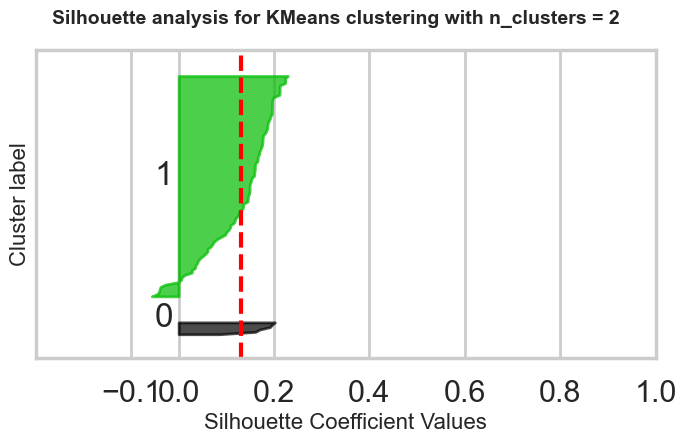

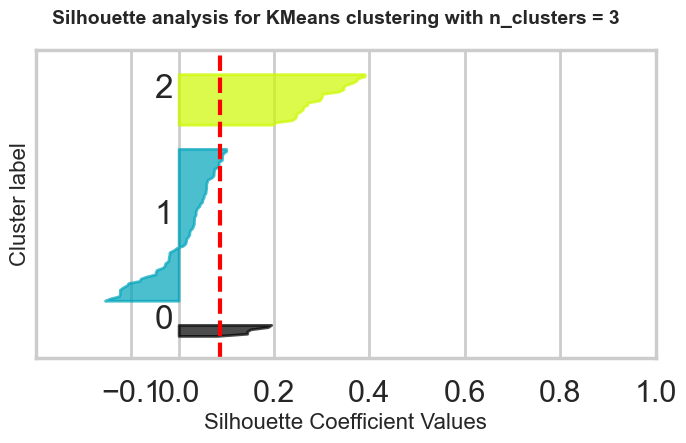

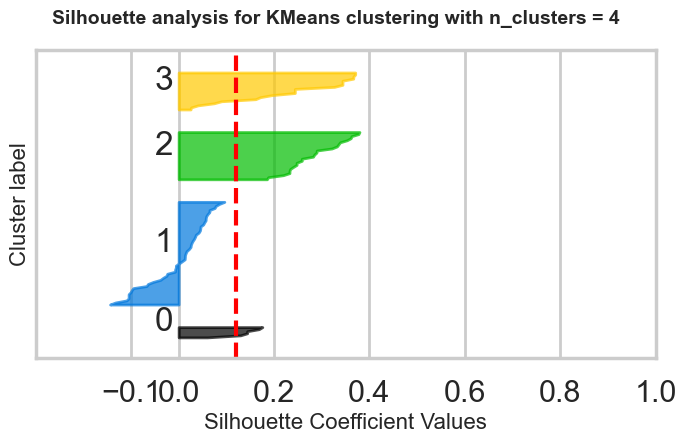

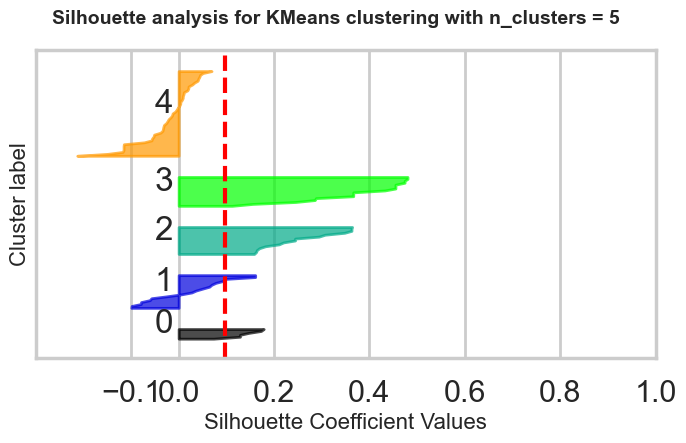

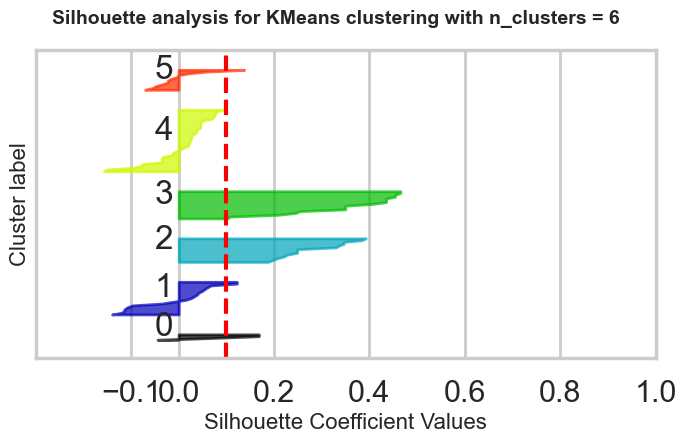

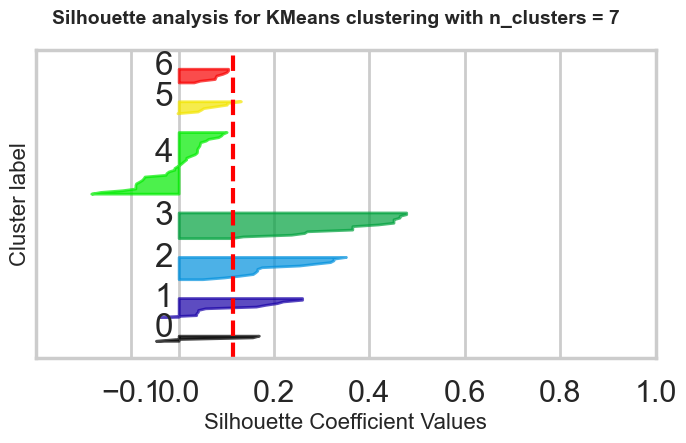

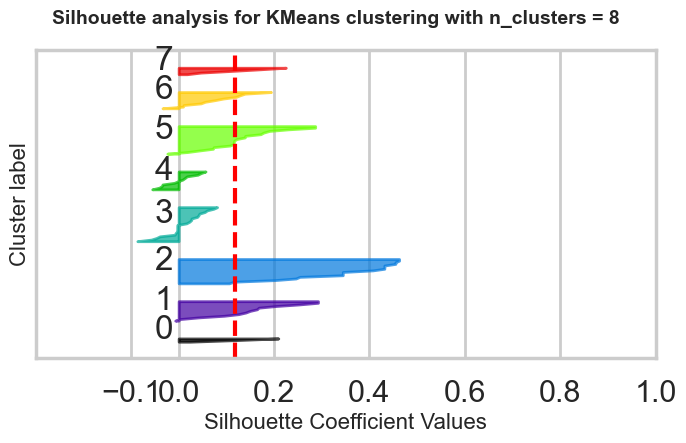

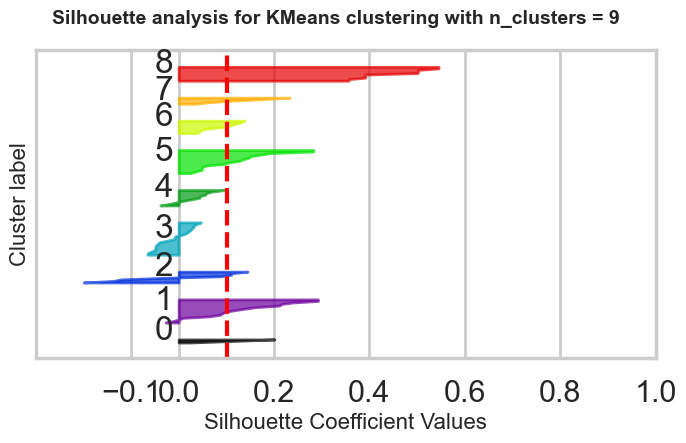

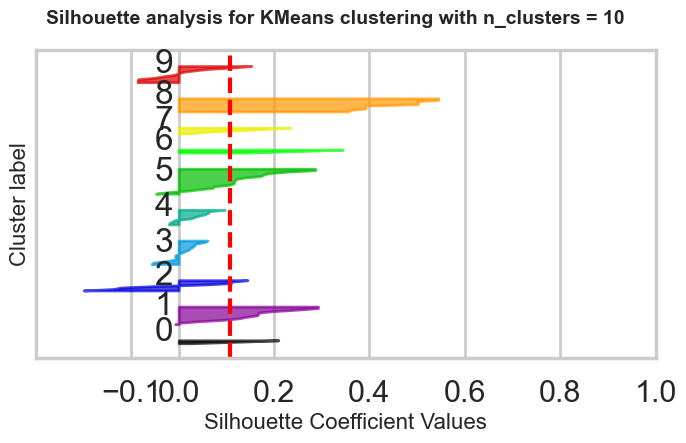

In [34]:
# Your turn.
# This following code was taken from the above resource and edited to fit this case study. 
silhouette_avg = []
for k in k_values:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    ax.set_xlim([-0.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(labels) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    y_pred = model.fit_predict(x_cols)

    # Calculate the silhouette_score, which gives the average value for all the samples, and append to silhouette_avg for later use
    score = silhouette_score(x_cols, y_pred)
    silhouette_avg.append(score)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, y_pred)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_xlabel("Silhouette Coefficient Values", fontsize=16)
    ax.set_ylabel("Cluster label", fontsize=16)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering with n_clusters = %d"
        % k,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

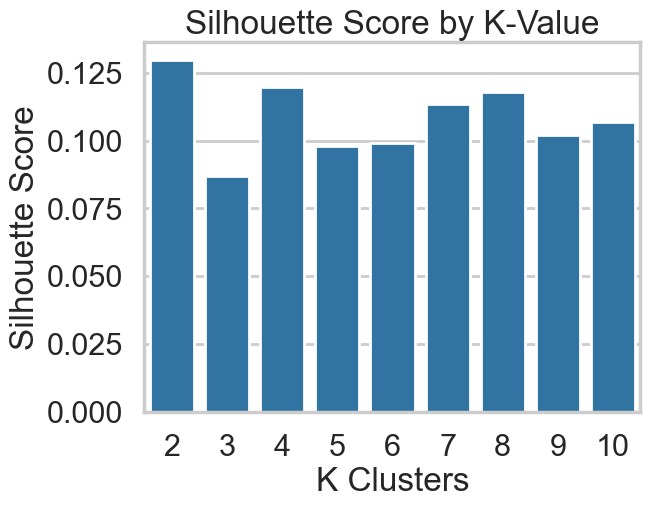

In [37]:
#Plot the silhouette scores for each k tested
sns.barplot(x=k_values, y=silhouette_avg)
plt.title('Silhouette Score by K-Value')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Devon's Answer: This method of choosing a k value was similarly unsatisfactory for this dataset.  All silhouette scores are well below the desired minimim of 0.51, indicating that the clusters are overlapping and not particularly informative.  I definitly prefer this method, as it showed me how bad all of these clusters are, while the elbow method just didn't give a clear answer as to the best k value.  If I had to pick a k value based on the silhouettes scores, I would choose 4 since it has the highest score after 2 (and 2 really seems too low for this many data points) However, the real answer is that I would look at other algorithms to see if they could do a better job with this data than KMeans. 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

### Exercise 1

In [42]:
#your turn
# First I will run the PCA and start the data frame with PC1 and PC2 columns
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_cols)
df_pca = pd.DataFrame({'customer_name':df_transactions_pivot['customer_name'], 'PCA1':x_pca[:,0], 'PCA2':x_pca[:,1]})
df_pca.head()


,customer_name,PCA1,PCA2
0,Adams,1.007580,0.108215
1,Allen,-0.287539,0.044715
2,Anderson,-0.392032,1.038391
3,Bailey,0.699477,-0.022542
4,Baker,0.088183,-0.471695


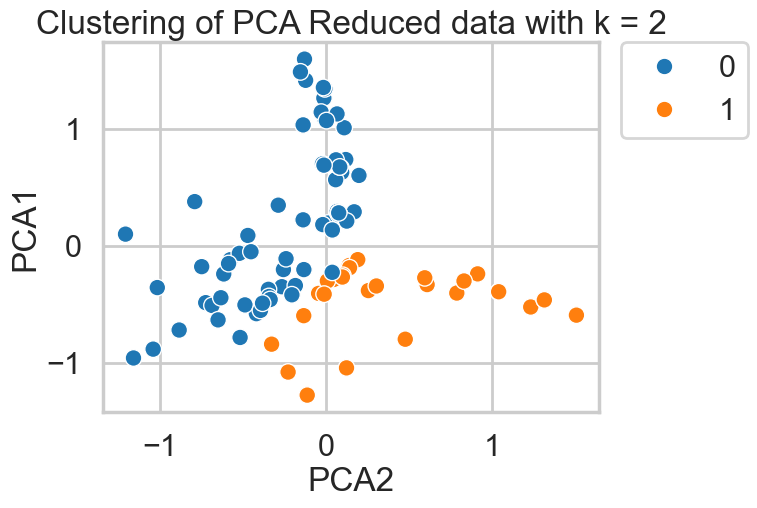

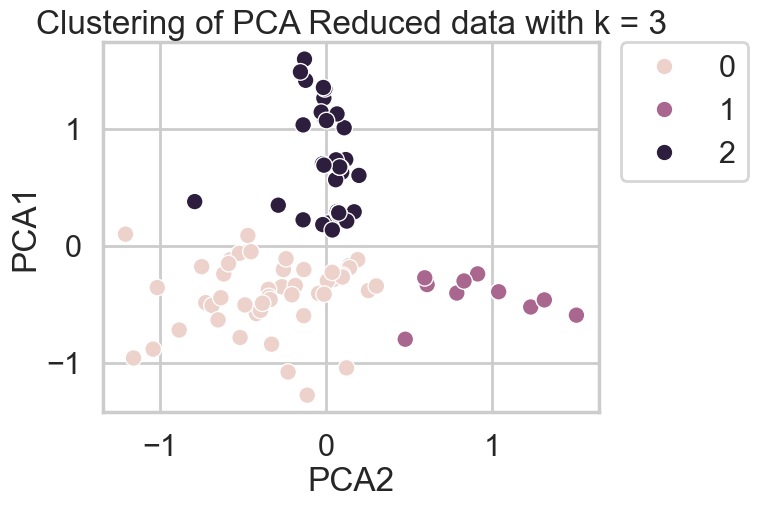

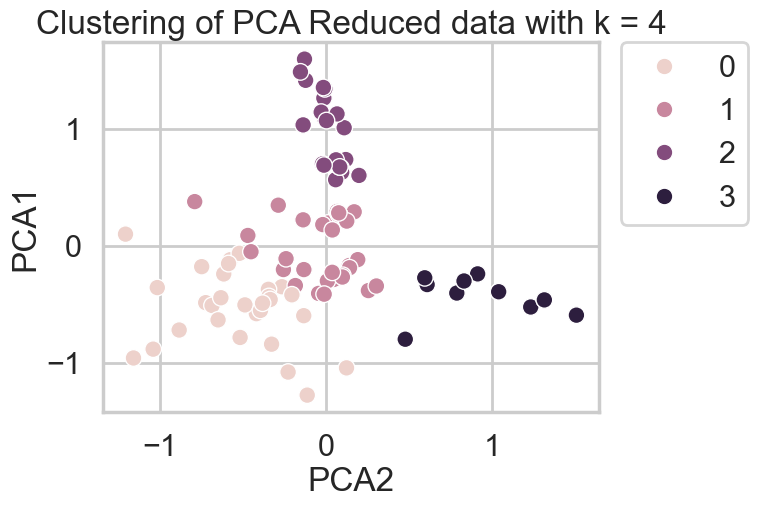

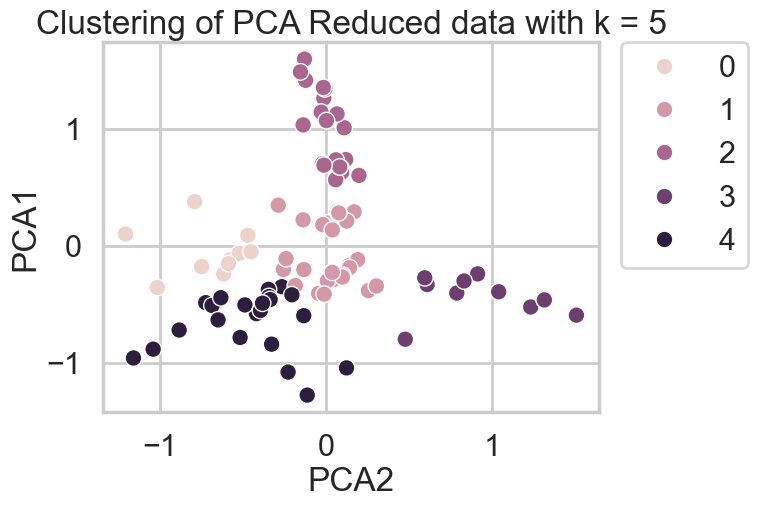

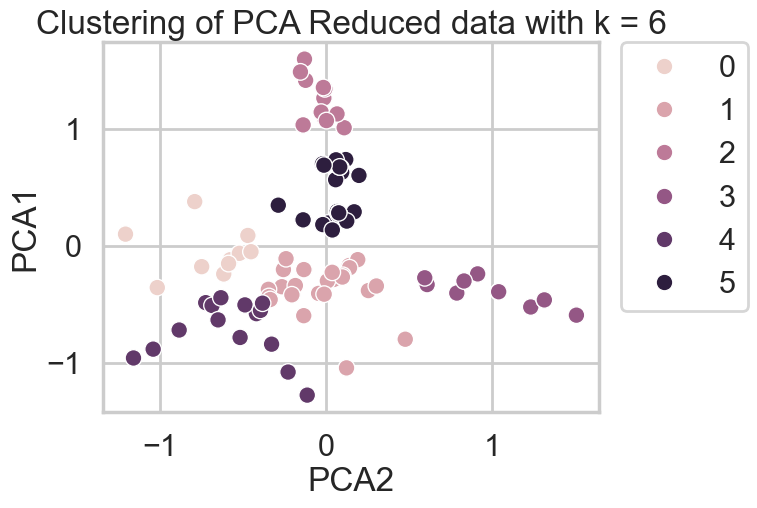

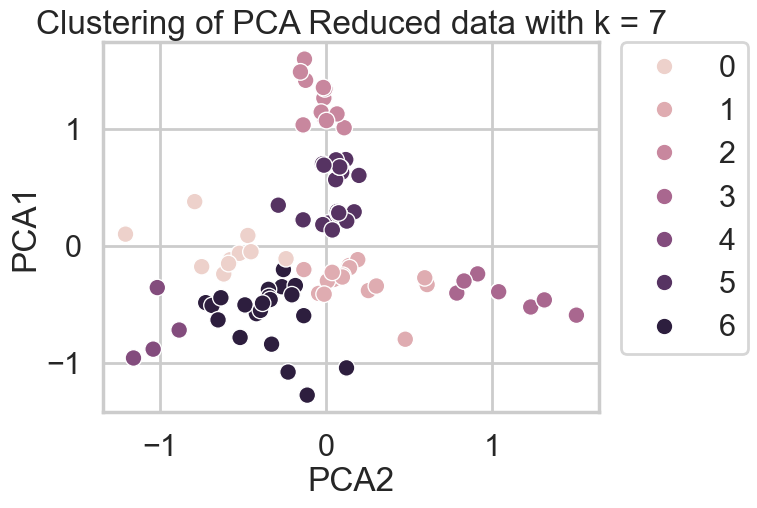

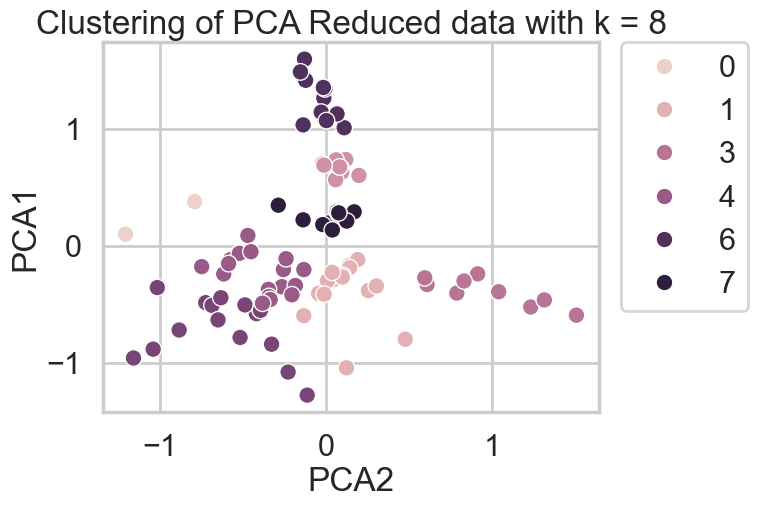

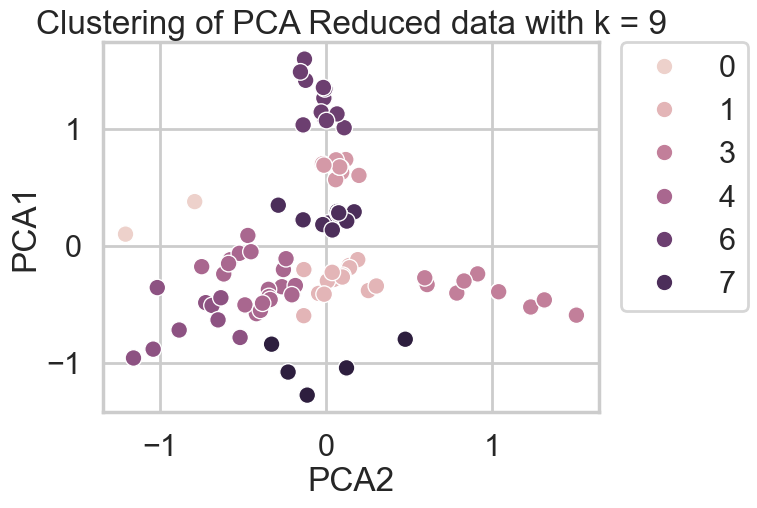

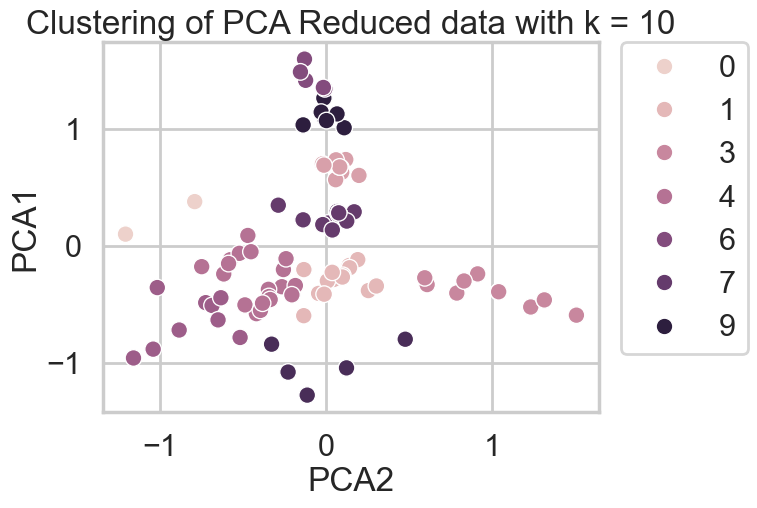

In [58]:
# I will use the silhouette method to find optimal k value when clustering on the PCA data.
pca_score = []
for k in k_values:  
    model = KMeans(n_clusters=k, random_state=10)
    y_pred = model.fit_predict(x_pca)
    score = silhouette_score(x_cols, y_pred)
    pca_score.append(score)

    pca_labels = model.labels_
    df_pca['cluster_id'] = pca_labels

    sns.scatterplot(data=df_pca, x='PCA2', y='PCA1', hue='cluster_id')
    plt.xlabel('PCA2')
    plt.ylabel('PCA1')
    plt.title(f'Clustering of PCA Reduced data with k = {k}')
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
    plt.show()

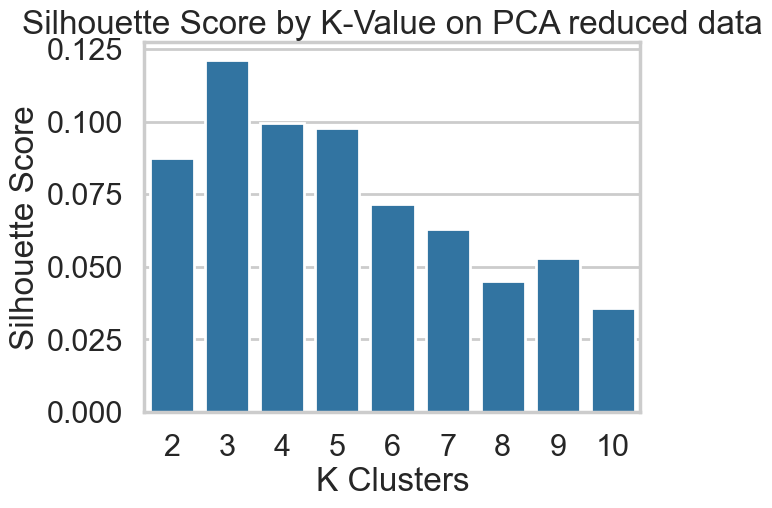

In [59]:
#Plot the silhouette scores for each k tested
sns.barplot(x=k_values, y=pca_score)
plt.title('Silhouette Score by K-Value on PCA reduced data')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Devon's Answer: Both visual inspection of clusters and comparing silhouette scores suggest that k=3 is optimal for KMeans clustering on this data following PCA dimension reduction. I think that three clusters looks the best, in that the clusters look somewhat separated from each other.  Additional clusters look like overfitting to me.

In [ ]:
# For the sake of completion, I'll now perform KMeans on the PCA reduced data with k=3 and complete the data frame.
kmeans = KMeans(n_clusters=3)
kmeans.fit_transform(x_pca)
pca_labels = kmeans.labels_
df_pca['cluster_id'] = pca_labels
df_pca.head()

,customer_name,PCA1,PCA2,cluster_id
0,Adams,1.007580,0.108215,1
1,Allen,-0.287539,0.044715,2
2,Anderson,-0.392032,1.038391,0
3,Bailey,0.699477,-0.022542,1
4,Baker,0.088183,-0.471695,2


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

### Exercise 2

In [ ]:
#To get the data together, I will add the cluster_id column to the x_cols data frame.
x_cols['cluster_id'] = df_pca['cluster_id']

In [ ]:
# Now group by cluster, summing accross offers to see which offers are in each cluster
df_cluster = x_cols.groupby('cluster_id').sum()
pd.set_option('display.max_columns', None)  # show all columns
display(df_cluster)

offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
cluster_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,6,0,0,0,0,0,0,0,1,0,1,0,0,0,1,7,0,0,0,0,0,1,12,0,12,1,0,0,0,0,0
1,0,0,2,0,0,1,16,17,1,2,1,1,6,0,0,1,0,13,1,0,2,1,0,0,1,0,1,1,16,18,0,0
2,9,4,4,12,4,11,3,3,9,4,12,3,0,9,6,3,0,1,4,6,2,20,4,0,5,3,7,5,1,4,17,4


Based on the above dataframe, we can see that different clusters feature different offers.  Here is a summary of the most clearly segregated offer ids by cluster:  
Cluster 0: 2, 17, 24, 26  
Cluster 1: 7, 8, 13, 18, 29, 30  
Cluster 2: 1, 4, 6, 9, 11, 14, 15, 19, 20, 27, 31 (Cluster 2 might be an 'other' cluster)

If we look at the data with the offer descriptions we can separate them by cluster and look for common features.

In [115]:
Cluster0 = df_offers[df_offers['offer_id'].isin([2, 17, 24, 26])]
Cluster0

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
1,2,January,Pinot Noir,72,17,France,False
16,17,July,Pinot Noir,12,47,Germany,False
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


In [116]:
Cluster1 = df_offers[df_offers['offer_id'].isin([7, 8, 13, 18, 29, 30])]
Cluster1

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
12,13,May,Merlot,6,43,Chile,False
17,18,July,Espumante,6,50,Oregon,False
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


In [117]:
Cluster2 = df_offers[df_offers['offer_id'].isin([1, 4, 6, 9, 11, 14, 15, 19, 20, 27, 31])]
Cluster2

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
8,9,April,Chardonnay,144,57,Chile,False
10,11,May,Champagne,72,85,France,False
13,14,June,Merlot,72,64,Chile,False
14,15,June,Cabernet Sauvignon,144,19,Italy,False
18,19,July,Champagne,12,66,Germany,False
19,20,August,Cabernet Sauvignon,72,82,Italy,False
26,27,October,Champagne,72,88,New Zealand,False


Based on the offers divided up by cluster, we can explain the different clusters as follows:

Cluster0: Exclusively Pinot Noir.  Customers in this cluster should be shown advertisements highlighting this type of wine.  
Cluster1: Minimum quantitiy of 6 bottles.  Customers in this cluster should be shown advertisements with discounts applicable to small orders.  
Cluster2: No clear pattern.  As expected, this cluster appears to group customers not in either of the other two clusters. I would guess that increasing the number of clusters would split this cluster, although that could cause overfitting.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [102]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca_dimensions = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
explained_variance = []    
pca_op = sklearn.decomposition.PCA(n_components=10)
pca_op.fit_transform(x_cols)
df_var = pca_op.explained_variance_ratio_
df_var

array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334])

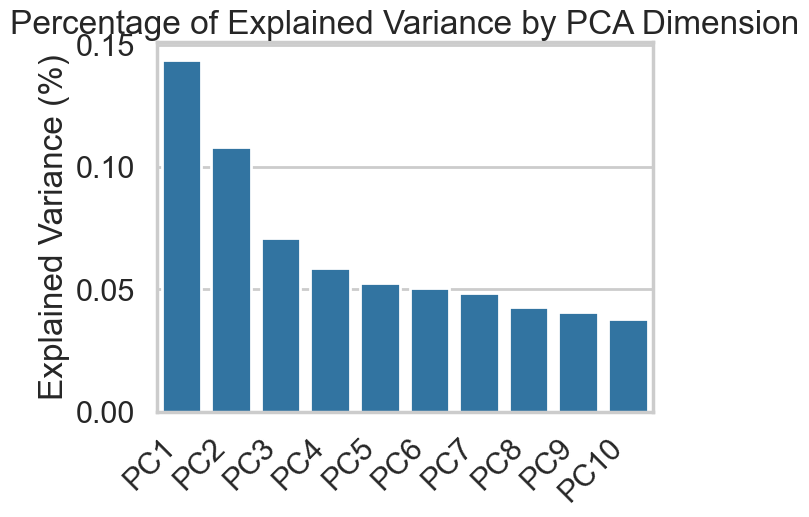

In [103]:
sns.barplot(y=df_var, x=pca_dimensions)
plt.title('Percentage of Explained Variance by PCA Dimension')
plt.ylabel('Explained Variance (%)')
plt.xticks(rotation=45, ha='right')
plt.show()


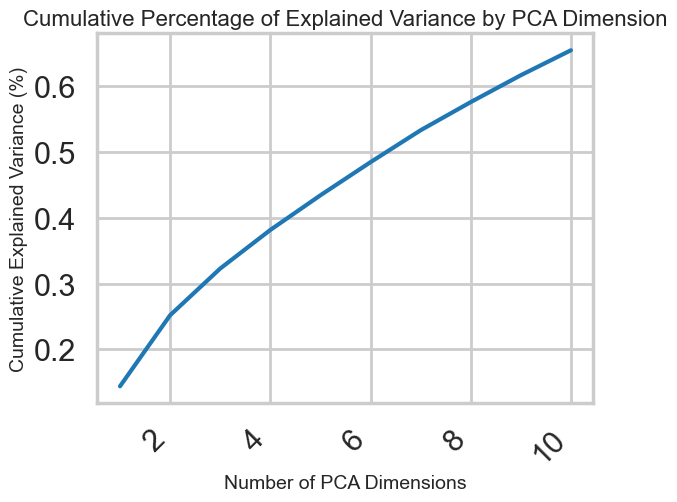

In [105]:
cumulative_variance = np.cumsum(df_var)
sns.lineplot(x=range(1,11), y=cumulative_variance)
plt.title('Cumulative Percentage of Explained Variance by PCA Dimension', fontsize=16)
plt.ylabel('Cumulative Explained Variance (%)', fontsize=14)
plt.xlabel('Number of PCA Dimensions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

Devon's Answer: Based on these graphs, the 'elbow' happens at PC3, although it's a pretty subtle elbow on the cumulative plot.  These results weakly support using 2 dimensions in the PCA dimension reduction.  However, the optimal number of dimensions is based on the model's intended use. The first two dimensions explain more variance than any others, but they still only explain 25% of total variance.  More dimensions might be needed (probaly 8-10 dimensions) if greater accuracy is required.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

Devon's Answer: Applying PCA with 2 dimensions followed by KMeans clusterting into three clusters seemed to be the best way to get useful information out of this data.  The clusters seemed to make sense, with Clusters 0 and 1 have easily identifiable commonalities between customers and Cluster2 being a catch-all for everything else.  In order to confirm that we have the optimal clustering, I would want to look at the contents of the clusters in a few other scenarios to see if they make sense.  Here is what I would try:

- PCA dimensions = 2, with 3 or 4 clusters. Does this split of Cluster2 in way that makes sense?
- PCA dimensions = 10, find the optimal k value using silhouette scores. Does accounting for more variability make the clusters more or less interpretable?

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


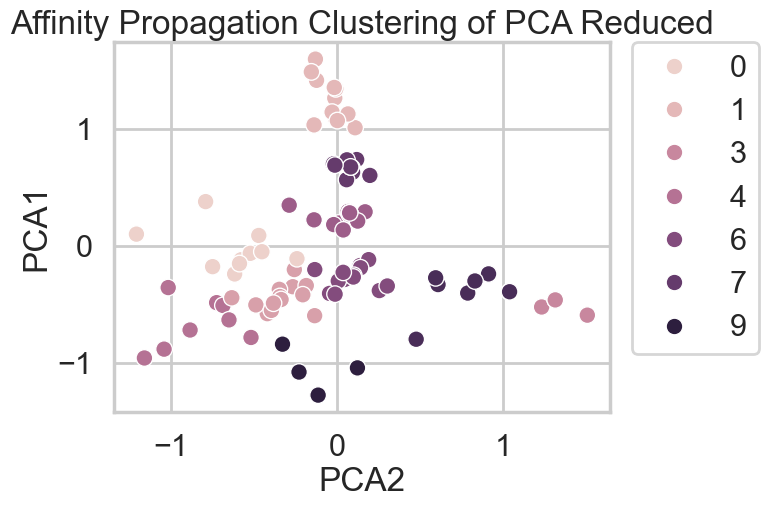

In [ ]:
# Your turn
#Affinity Propagation
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(x_pca)
df_pca['affinity_cluster'] = ap.labels_

sns.scatterplot(data=df_pca, x='PCA2', y='PCA1', hue='affinity_cluster')
plt.xlabel('PCA2')
plt.ylabel('PCA1')
plt.title('Affinity Propagation Clustering of PCA Reduced Data')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
plt.show()


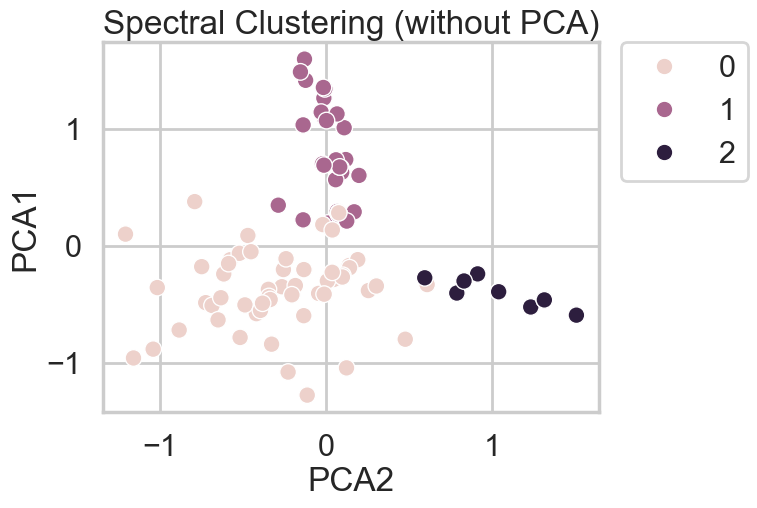

In [ ]:
#Spectral Clustering
from sklearn.cluster import SpectralClustering
x_cols = x_cols.drop('cluster_id', axis=1)
sp = SpectralClustering(n_clusters=3)
sp.fit_predict(x_cols)
df_pca['spectral_clustering'] = sp.labels_
# For simplicities sake, I will still use the PCA1 and PCA2 to graph the data
sns.scatterplot(data=df_pca, x='PCA2', y='PCA1', hue='spectral_clustering')
plt.xlabel('PCA2')
plt.ylabel('PCA1')
plt.title('Spectral Clustering (without PCA)')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
plt.show()

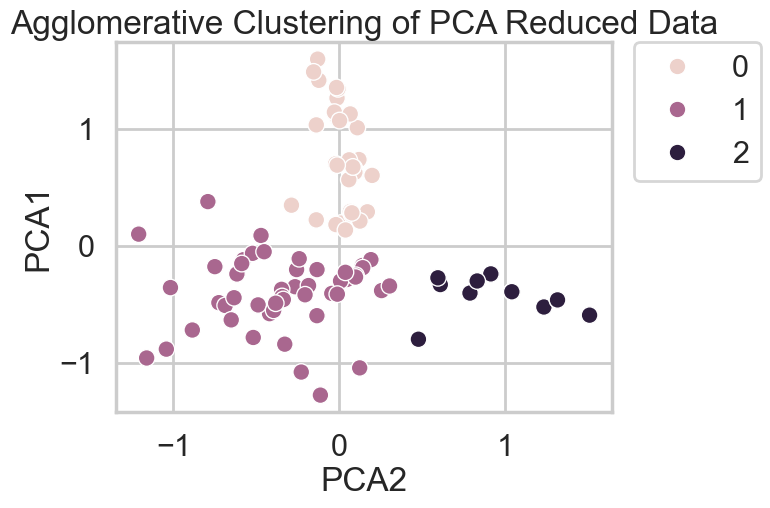

In [139]:
#Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3)
ac.fit_predict(x_pca)
df_pca['agglomerative_cluster'] = ac.labels_

sns.scatterplot(data=df_pca, x='PCA2', y='PCA1', hue='agglomerative_cluster')
plt.xlabel('PCA2')
plt.ylabel('PCA1')
plt.title('Agglomerative Clustering of PCA Reduced Data')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
plt.show()

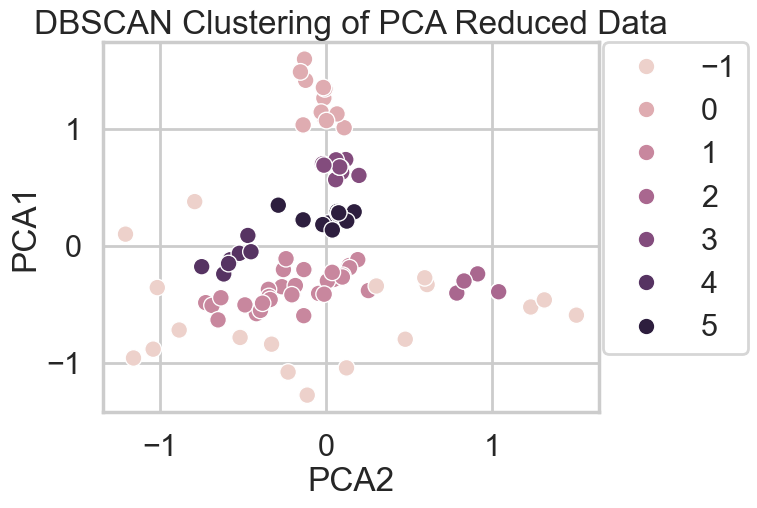

In [135]:
#DBSCAN - I tried a few window sizes and settled on 0.2 making the most sense for this data, based on visual inspection of the clusters. 
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2)
db.fit_predict(x_pca)
df_pca['dbscan'] = db.labels_

sns.scatterplot(data=df_pca, x='PCA2', y='PCA1', hue='dbscan')
plt.xlabel('PCA2')
plt.ylabel('PCA1')
plt.title('DBSCAN Clustering of PCA Reduced Data')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
plt.show()

Devon's Answer: I think that the Affinity Propogation and the Agglomerative Clustering worked the best on this data.  The DBSCAN really struggled to find something that makes sense, I don't think that there is enough variation in the data density for that algorithm to makes sense. Also, the Spectral Clustering showed overlapping clusters, although I fully recognize that this could have been a side effect of plotting the data useing the PCA dimension reduction data.  I'm not sure how to do a proper comparison with this clustering method with plotting.

Affinity Propagation - this method looked like it did good job a picking out smaller clusters in a way that visually made sense.  It seemed less 'overfit' than the KMeans plots with similar numbers of clusters.  However, the data still looks overfit to me, so this isn't the method I would chose without more hyperparameter tuning.

Agglomerative Clustering - This one is my favorite.  I like the control of being able to chose the cluster number, and the clusters make more sense to me as I increase the cluster number compared to KMeans.  In particular, the two methods diverge at 5+ clusters, with clearer visual distinctions between the clusters generated by the Agglomerative model.  At k=3, the clustering is identicle between the two models (except for one data point).  Above, when we looked at the contents of the three clusters, we found that Cluster0 and Cluster1 had clear definitions while Cluster2 looked like catch-all.  When k is increased to 5, the Agglomerative model splits up Cluster2, while KMeans splits up Cluster0. I'm oversimpliying this, but essentially it looks like the clustering with the Agglomertive method makes more sense based on what we already know.  To get a more definity answer, I would look at the specific contents of the 5 clusters generated by each model.